In [6]:
sys.path.append(os.path.abspath(os.path.join('..', 'code')))

In [7]:
import torch
import random
import os
from os import path
import sys
import scanpy as sc
import squidpy as sq
import scipy.sparse as sp
import numpy as np
from sklearn.decomposition import NMF
import gpzoo.pri_experiment_utilities as exp
from torch import nn
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gpzoo.pri_experiment_utilities as exp
from gpzoo.utilities import rescale_spatial_coords
from main import calcalculate_radius, calculate_gradients_for_high_expressing_cells, find_neighbors_within_radius, normalize_coordinates

In [8]:
random.seed(256)
root_path = '/engelhardt/home/pshrestha/spatial_gradients_project/'
dtp = "float32"
dpath = path.join(root_path, "data/")

In [9]:
print("CUDA available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available:  True
Number of GPUs:  2
Current GPU:  0
GPU Name:  NVIDIA A30


In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")
device

device(type='cpu')

## Data Discovery

In [11]:
adata = sq.datasets.visium_hne_adata()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
Y_sums = np.array(np.sum(adata.raw.X > 0, axis=0))[0]
    
Y = np.array(adata.raw.X[:, Y_sums>200].todense(), dtype=int)
X = adata.obsm['spatial']
X = X.astype('float64')
Y = Y.astype('float64')
X = rescale_spatial_coords(X)

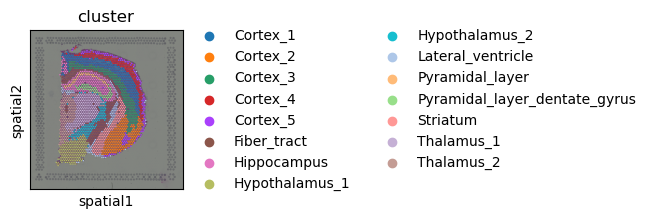

In [12]:
sq.pl.spatial_scatter(adata, color='cluster', size=1.2)

In [13]:
print(X.shape)
print(Y.shape)

(2688, 2)
(2688, 11925)


In [14]:
# Set up NMF
L = 10
max_iter = 100
nmf_model = NMF(n_components=L, max_iter=max_iter, init='nndsvd', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [15]:
nmf_model.fit(Y)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='nndsvd', max_iter=100, n_components=10,
    random_state=0)

In [16]:
exp_factors = nmf_model.transform(Y)

In [17]:
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T

In [18]:
moran_idx, moranI = exp.dims_autocorr(np.exp(factors), X)

In [19]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

(<Figure size 1000x400 with 10 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

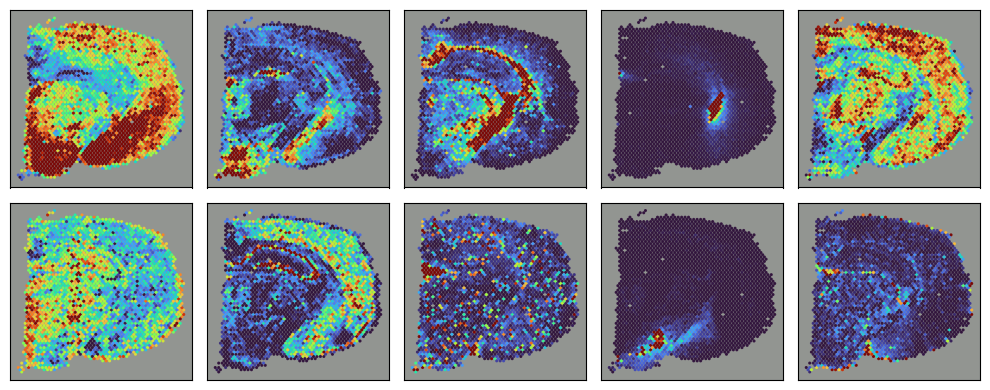

In [20]:
exp.plot_factors(np.exp(factors_ordered).T, X, moran_idx=None, size=2, s=1.5, alpha=0.9)

## Gradient Calculation

In [21]:
X_norm = normalize_coordinates(X) # normalizing AFTER scaling

In [23]:
# Normalize X coordinates
X_norm = normalize_coordinates(X)

# Set expression threshold and radius
expression_threshold = np.percentile(gene, 75)  # Use top 25% expressing cells
radius = np.percentile(np.linalg.norm(X_norm - X_norm.mean(axis=0), axis=1), 15)  # Use 15th percentile of distances as radius

# Find cells above threshold
high_expressing = gene > expression_threshold

NameError: name 'gene' is not defined

In [ ]:
# Find neighbors within radius for each high expressing cell
distances, indices = find_neighbors_within_radius(X_norm, radius, high_expressing)

# Calculate gradients only for high expressing cells
dx_local, dy_local = calculate_gradients_for_high_expressing_cells(X_norm, gene, distances, indices)